<center><h1>YOLO11 Training with Privileged Information</h1>
<h2>Matthias Bartolo</h2>

</center>

<h3>Package Imports</h3>

In [1]:
# !pip install --upgrade roboflow ultralytics

In [2]:
# !pip install rasterio

**<h3>Required libraries.</h3>**
https://github.com/ultralytics/ultralytics/issues/2154

In [1]:
import torch
import os
# import ultralytics
import locale
import glob
import pandas as pd
import matplotlib.pyplot as plt

from IPython import display
from ultralytics import YOLO
from IPython.display import display, Image
from roboflow import Roboflow

%matplotlib inline

**<h3>Using GPU if one is available.</h3>**

In [2]:
!nvidia-smi

Mon Jan 27 16:06:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P5             18W /  200W |    1786MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# Retrieving the current working directory
HOME = os.getcwd()
print(HOME)

e:\Testing


**<h3>Downloading the Roboflow dataset.</h3>**

In [9]:
if not os.path.isdir(os.path.join(HOME, 'datasets')):
    os.mkdir(os.path.join(HOME, 'datasets'))
os.chdir(os.path.join(HOME, 'datasets'))


# Zoo Animals Dataset
rf = Roboflow(api_key="nyynHs3oneLLx01D04rC")
project = rf.workspace("kyle-pelham-tieix").project("zoo-animals")
version = project.version(2)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


**<h3>Training the YOLO11 model.</h3>**

In [6]:
# Added Code for Custom 4 Channel YOLO Model:
import torch.nn as nn

# Define the custom YOLO model class (Not working)
class CustomYOLO(YOLO):
    def __init__(self, model_path, num_channels):
        """
        Initialize the custom YOLO model by adding a custom beginning layer for multi-channel input.
        
        Args:
            model_path (str): Path to the pre-trained YOLO model.
            num_channels (int): Number of input channels (e.g., 3 for RGB, 4 for RGB + edge).
        """
        # Load the original YOLO model from the given path
        super(CustomYOLO, self).__init__(model_path)
        
        # Access the first convolutional layer of the YOLO model
        # self.model.model[0] is the first Conv2d layer (backbone structure)
        # You need to directly assign the custom convolutional layer to this part of the model.
        # Layer is the same as the normal YOLO model, but input has more channels
        self.model.model[0] = nn.Sequential(
            nn.Conv2d(num_channels, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.SiLU(inplace=True)
        )

    def forward(self, x):
        """
        Forward pass through the model.
        
        Args:
            x (torch.Tensor): Input tensor with multi-channel data.
        
        Returns:
            torch.Tensor: The model output after passing through the custom and YOLO layers.
        """
        return super(CustomYOLO, self).forward(x)

# Specify the model path and number of input channels
model_path = 'yolo11n.pt'  # Path to your YOLO model file
num_channels = 4  # Example for multi-channel input (e.g., RGB + edge detection)

# UltraLytics YOLO Model
# from ultralytics.nn.modules.conv import Conv  # Import the Conv layer from YOLO's common module

class CustomYOLO(YOLO):
    def __init__(self, model_path, num_channels):
        """
        Initialize the custom YOLO model by adding a custom beginning layer for multi-channel input.
        
        Args:
            model_path (str): Path to the pre-trained YOLO model.
            num_channels (int): Number of input channels (e.g., 3 for RGB, 4 for RGB + edge).
        """
        # Load the original YOLO model from the given path
        super(CustomYOLO, self).__init__(model_path)
        
        # Modify the first convolution to handle multi-channel input (num_channels)
        self.model.model[0].conv = nn.Conv2d(num_channels, 16, kernel_size=3, stride=2, padding=1, bias=False)

# Initialize the custom YOLO model
model = CustomYOLO(model_path, num_channels)

print(model)


CustomYOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_ru

In [7]:
sample_input = torch.randn(1, 4, 640, 640)  # Example input with batch size 1 and multi-channel data
# Normalise sample input to be between 0 and 1
sample_input = (sample_input - sample_input.min()) / (sample_input.max() - sample_input.min())
print(sample_input.shape)
output = model(sample_input)
print(output)

torch.Size([1, 4, 640, 640])



RuntimeError: Given groups=1, weight of size [16, 4, 3, 3], expected input[1, 3, 640, 640] to have 4 channels, but got 3 channels instead

In [ ]:
# Specifying the paths
yaml_path  = dataset.location+"/data.yaml"

# Specifying the model path
# model_path = 'yolo11n.pt'

# # Creating YOLO object
# model = YOLO(model_path)

# Specifying training parameters
num_epochs = 10  # Number of epochs
batch_size = 16 #8 # Adjust based on GPU memory
image_size = 640  # Decrease for faster training

# Training configuration
train_config = {
    'data': yaml_path,
    'imgsz': image_size,
    'batch': batch_size,
    'epochs': num_epochs,
    'device': 0,  # Use GPU 0
    # 'workers': 1,  # Number of data loading workers
    'optimizer': 'Adam',  # Use Adam optimizer
    'cache': True,  # Cache images for faster training
    'patience': 15,  # epochs to wait before decreasing LR
    'val': True,  # Run validation during training
    'plots': True,  # Run plots during training
}

# Train the model
model.train(**train_config)


Ultralytics 8.3.68  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=e:\Testing\datasets\Zoo-Animals-2/data.yaml, epochs=10, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

train: Scanning E:\Testing\datasets\Zoo-Animals-2\train\combined_images.cache... 0 images, 2969 backgrounds, 0 corrupt: 100%|██████████| 2969/2969 [00:00<?, ?it/s]

WARNING  No labels found in E:\Testing\datasets\Zoo-Animals-2\train\combined_images.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.0GB RAM):   1%|          | 23/2969 [00:04<08:15,  5.95it/s] 

**<h3>Validating the YOLO11 model on the Validation subset.</h3>**

In [ ]:
locale.getpreferredencoding = lambda: "UTF-8"
# !pip install aspose-words

In [ ]:
model.val() #This will output a train file however it will be on the validation data

Ultralytics 8.3.40  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLO11s-seg summary (fused): 265 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs


val: Scanning E:\Applications\datasets\UAVVASTE-1\valid\labels.cache... 153 images, 0 backgrounds, 0 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]
val: Caching images (0.2GB Disk): 100%|██████████| 153/153 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


                   all        153        834      0.779       0.53       0.61      0.349      0.738      0.505      0.561      0.263
Speed: 0.5ms preprocess, 6.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs\segment\train122


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000024B5B744D60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0410

**<h3>Validating the YOLO11 model on the Testing subset.</h3>**

In [ ]:
model.val(split='test') #This will output a train file however it will be on the test data

Ultralytics 8.3.40  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)


val: Scanning E:\Applications\datasets\UAVVASTE-1\test\labels... 77 images, 0 backgrounds, 0 corrupt: 100%|██████████| 77/77 [00:00<00:00, 1640.80it/s]

val: New cache created: E:\Applications\datasets\UAVVASTE-1\test\labels.cache



val: Caching images (0.1GB Disk): 100%|██████████| 77/77 [00:00<00:00, 1242.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


                   all         77        363      0.678       0.51      0.549      0.287      0.653      0.492      0.511      0.238
Speed: 1.4ms preprocess, 9.1ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs\segment\train123


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000024B5B777130>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0410

**<h3>Testing the YOLO11 model on the Testing subset.</h3>**

In [ ]:
!yolo task=detect \
mode=predict \
model={HOME}/datasets/runs/detect/train26/weights/best.pt \
source={dataset.location}/test/images \
save=True

Ultralytics 8.3.40 🚀 Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/77 e:\Applications\datasets\UAVVASTE-1\test\images\BATCH_d06_img_0_jpg.rf.c33a45f29e8e06aa9eb1eb42b2eaf817.jpg: 640x640 (no detections), 0.0ms
image 2/77 e:\Applications\datasets\UAVVASTE-1\test\images\BATCH_d06_img_130_jpg.rf.95dc857acb387c7da8a1f0f573a899d6.jpg: 640x640 (no detections), 0.0ms
image 3/77 e:\Applications\datasets\UAVVASTE-1\test\images\BATCH_d06_img_1440_jpg.rf.fa845092a1c1466e1cb39c51967a331a.jpg: 640x640 (no detections), 0.0ms
image 4/77 e:\Applications\datasets\UAVVASTE-1\test\images\BATCH_d06_img_2500_jpg.rf.4528263764fbd496609ff9f3a2e2603b.jpg: 640x640 3 trashs, 0.0ms
image 5/77 e:\Applications\datasets\UAVVASTE-1\test\images\BATCH_d06_img_3040_jpg.rf.045b7cfd6ae028e235e860c322b32d93.jpg: 640x640 (no detections), 5.5ms
image 6/77 e:\Applications\datasets\UAVVASTE-1\test\images\B

**<h3>Training Results.</h3>**

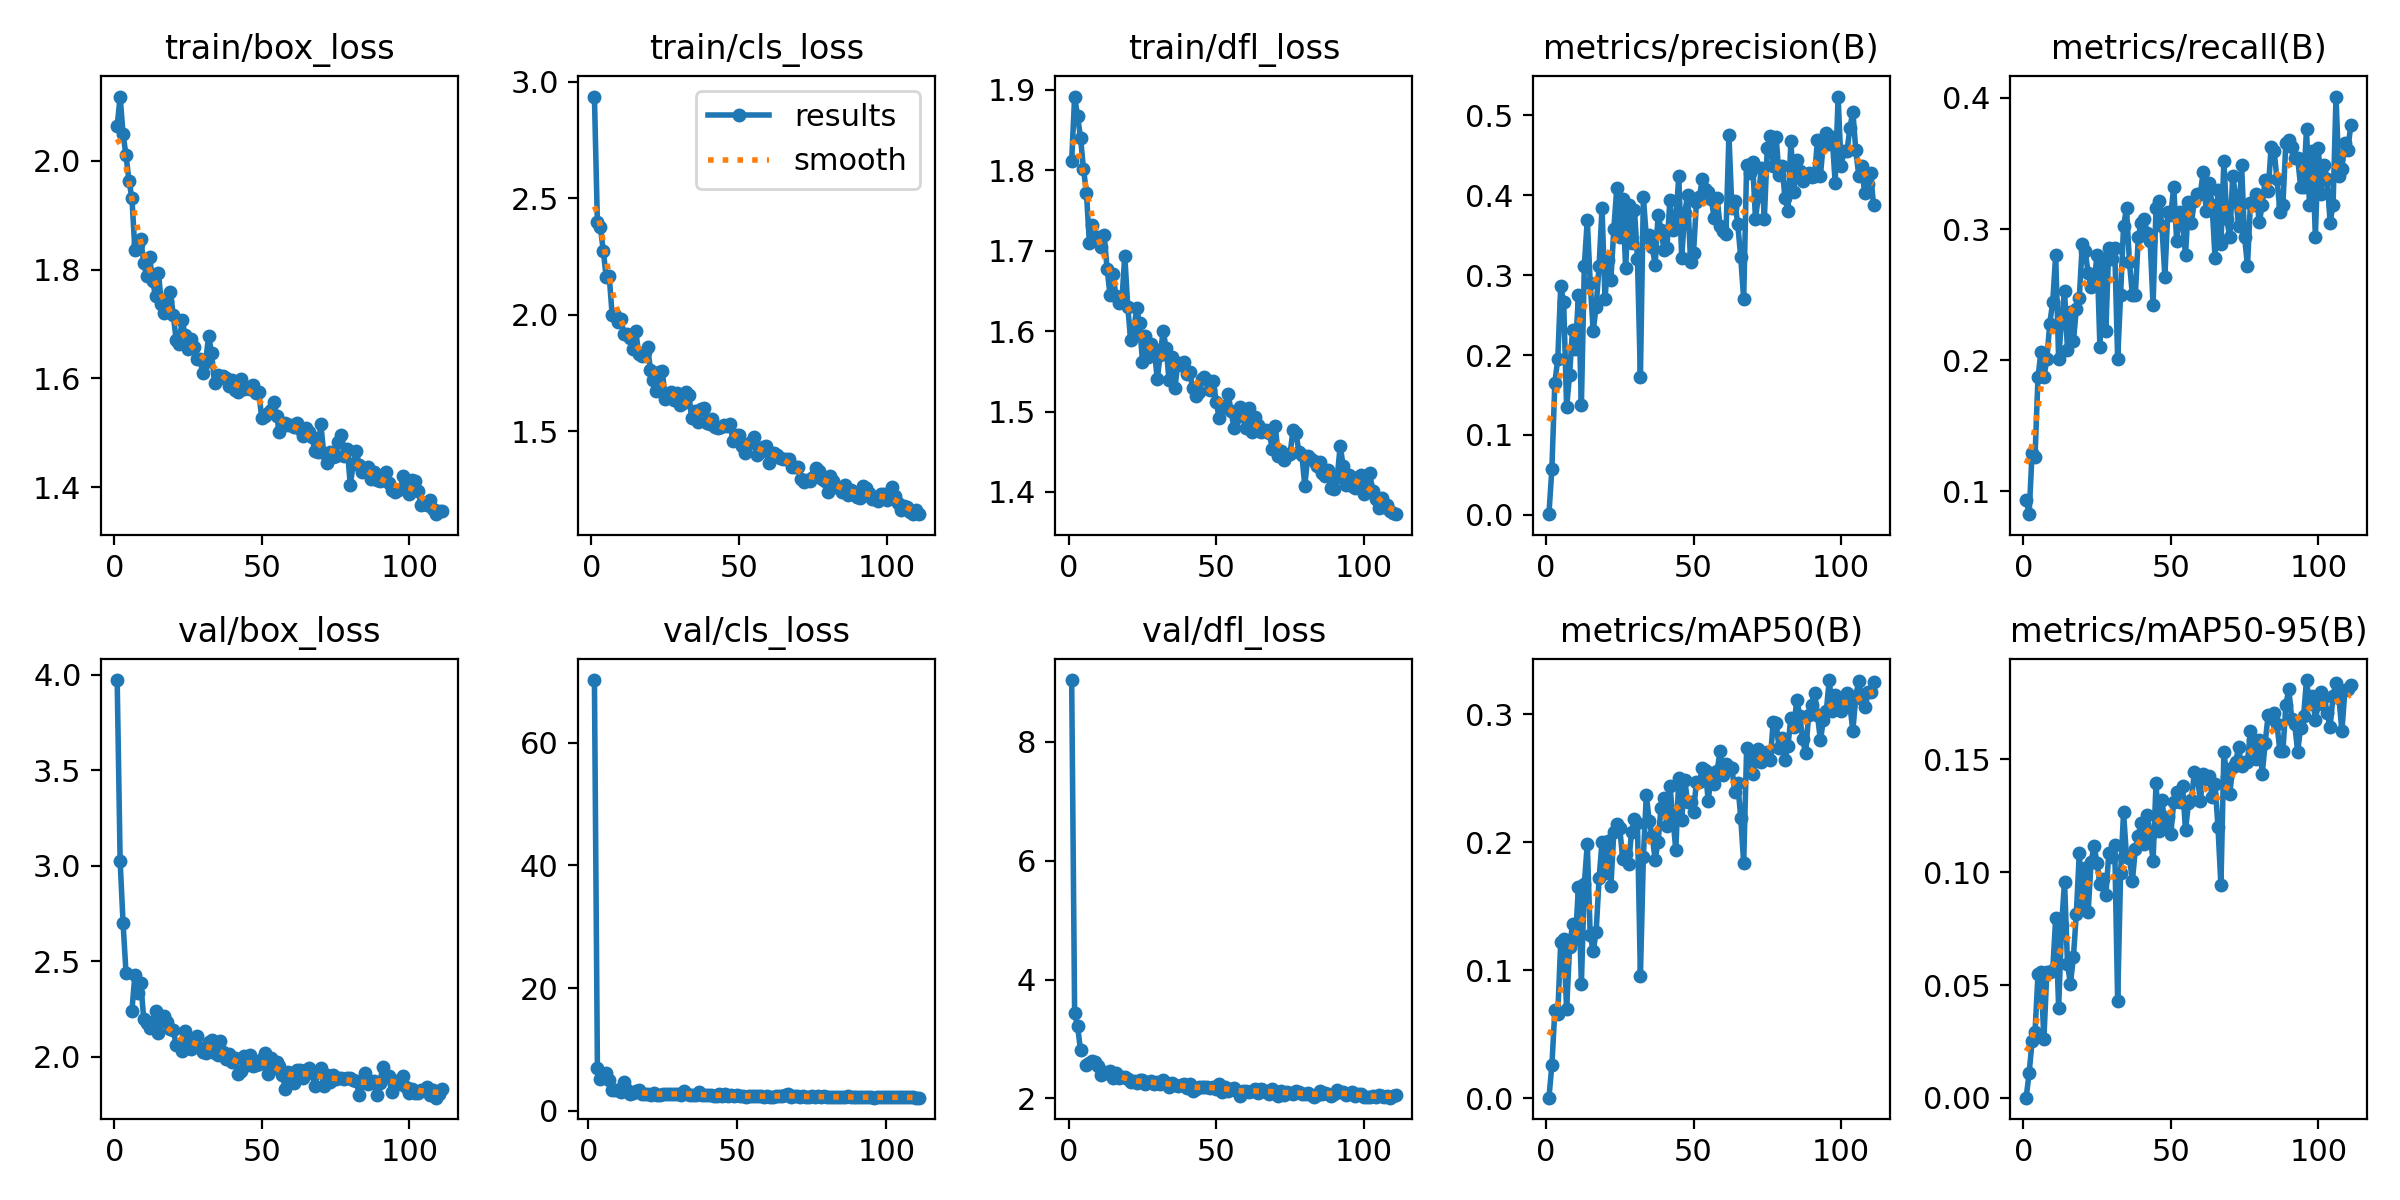

In [ ]:
# # Replace 'path/to/your/data.csv' with the actual path to your CSV file
# file_path = 'E:/Object_Detection/Work/SSUE/datasets/runs/detect/train6/results.csv'
# # file_path = 'E:/FishDetection/datasets/runs/detect/train2/results.csv'
# column_name = 'epoch'

# # Read the CSV file into a pandas DataFrame
# data = pd.read_csv(file_path)

# # Remove leading spaces from column names
# data.columns = data.columns.str.strip()

# # Plotting
# plt.figure(figsize=(12, 8))

# # Plotting the training losses
# plt.subplot(2, 2, 1)
# plt.plot(data['epoch'], data['train/box_loss'], label='Box Loss')
# plt.plot(data['epoch'], data['train/cls_loss'], label='Class Loss')
# plt.title('Training Losses')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Show the plots
# plt.tight_layout()
# plt.show()

from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/datasets/runs/detect/train26/results.png', width=600)

**<h3>Validation Results.</h3>**

In [ ]:
# # Plotting
# plt.figure(figsize=(12, 8))

# # Plotting the training losses
# plt.subplot(2, 2, 1)
# plt.plot(data['epoch'], data['val/box_loss'], label='Box Loss')
# plt.plot(data['epoch'], data['val/cls_loss'], label='Class Loss')
# plt.title('Validation Losses')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Show the plots
# plt.tight_layout()
# plt.show()

**<h3>Testing Resultant Images.</h3>**

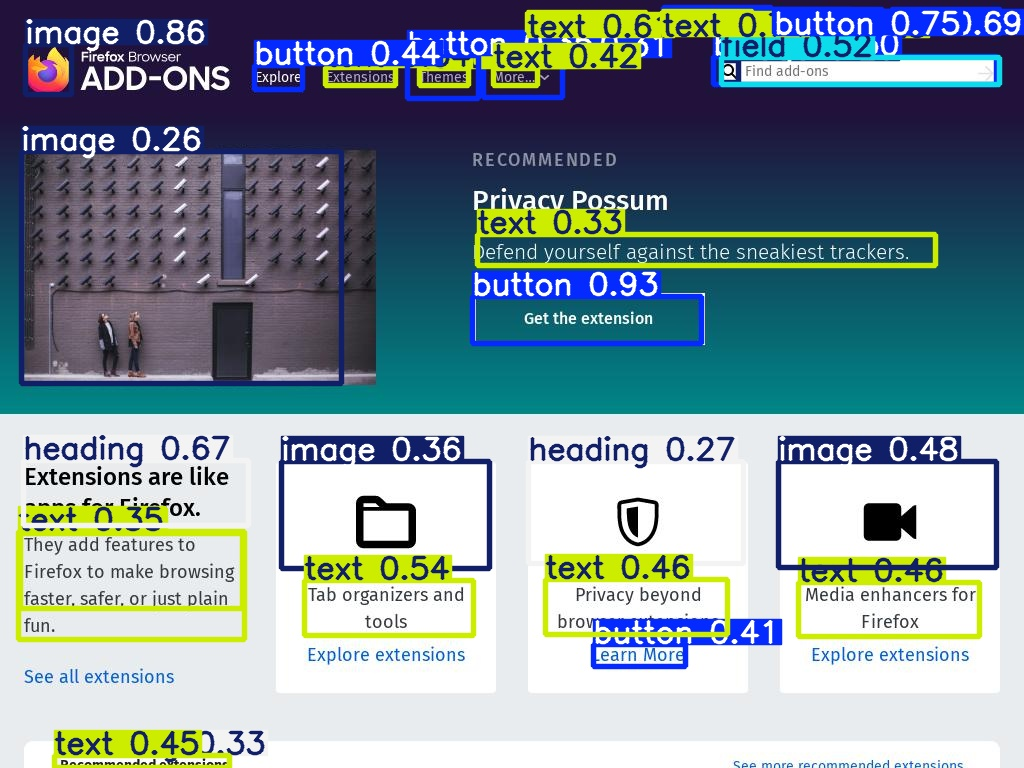

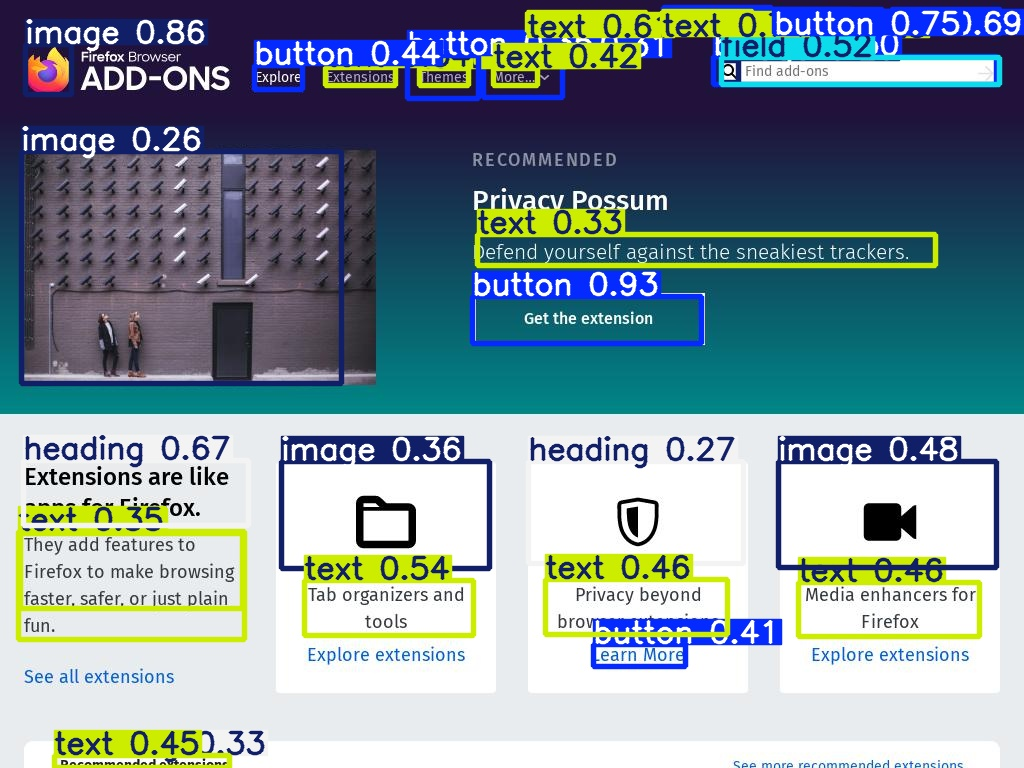

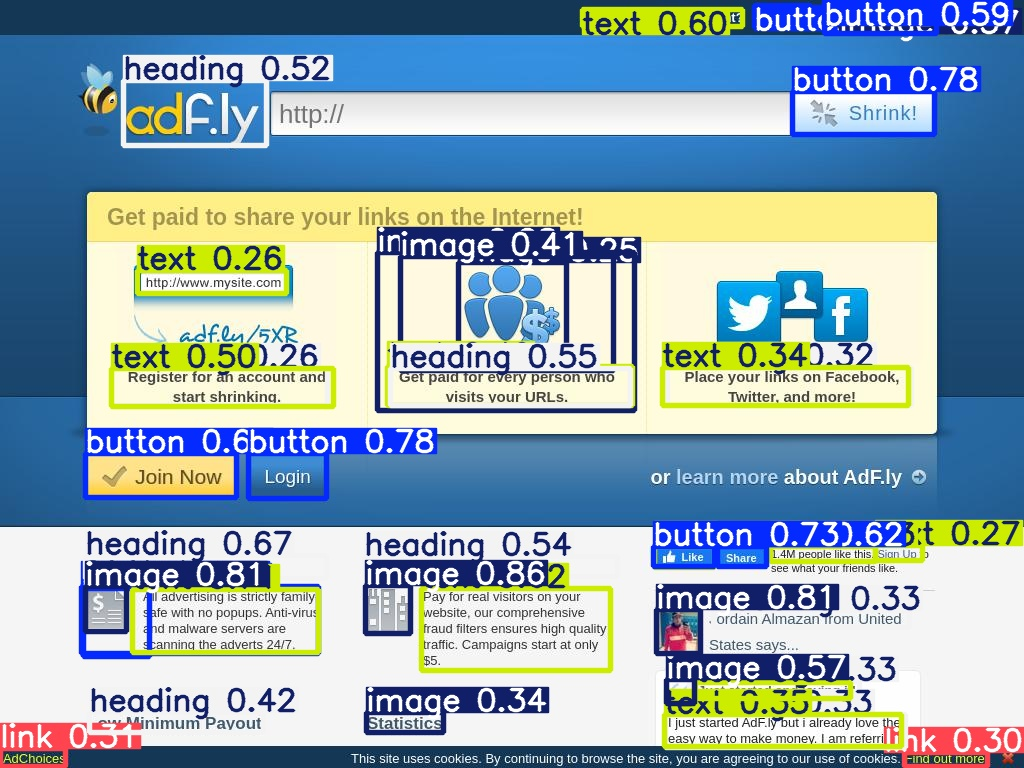

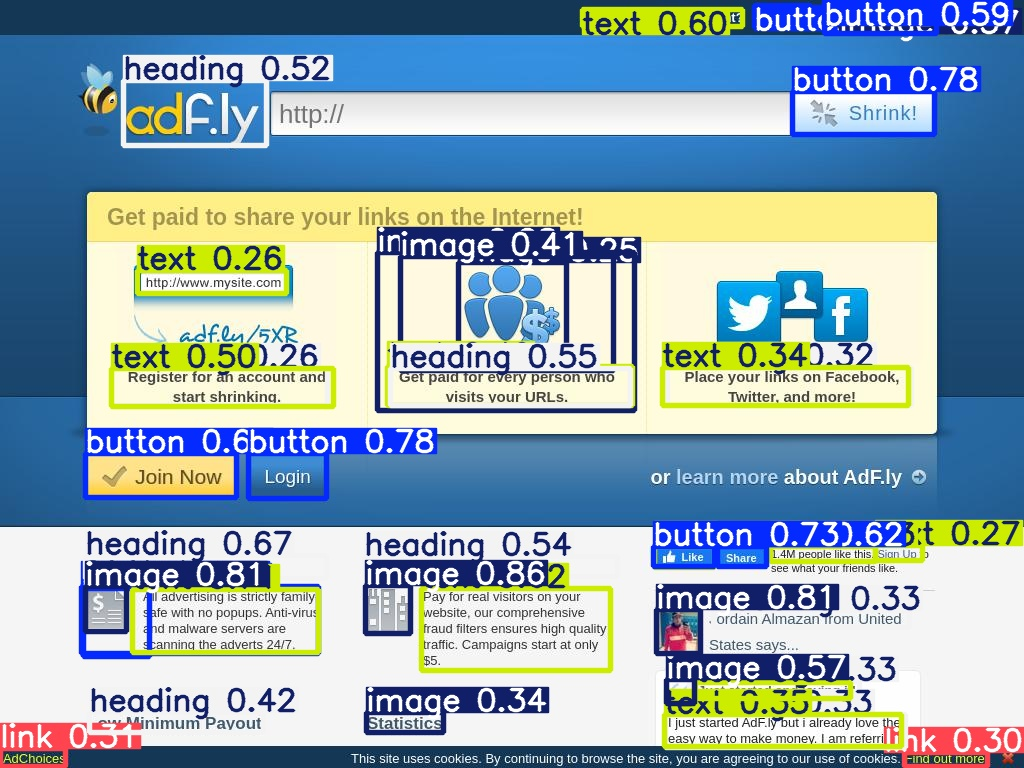

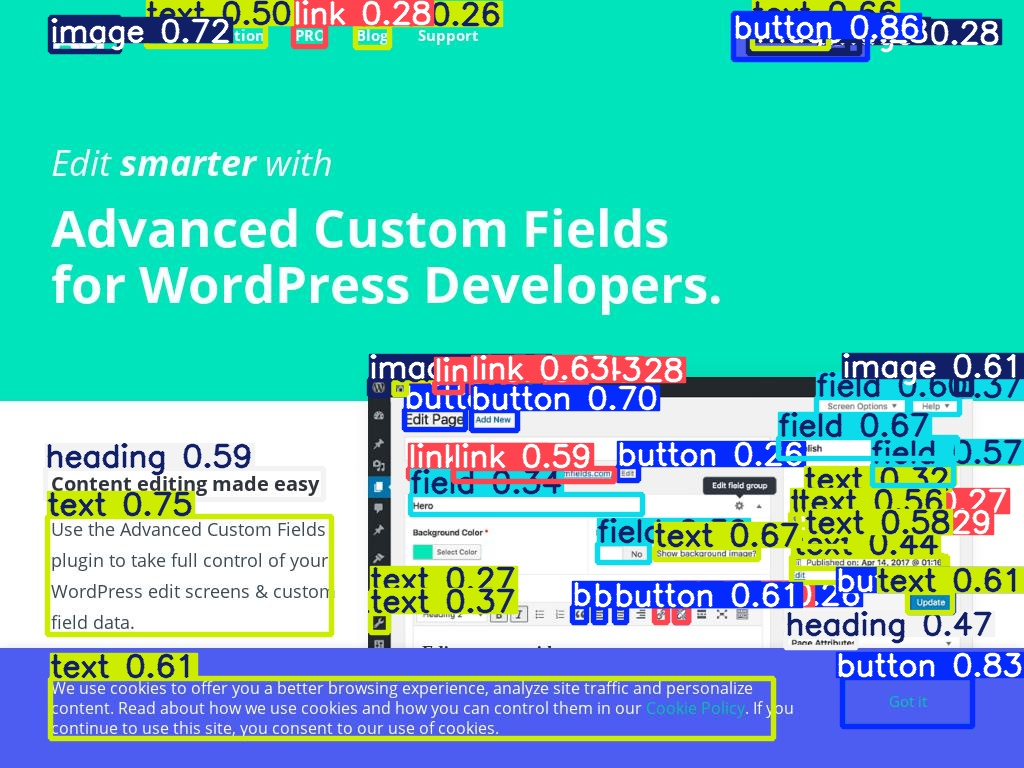

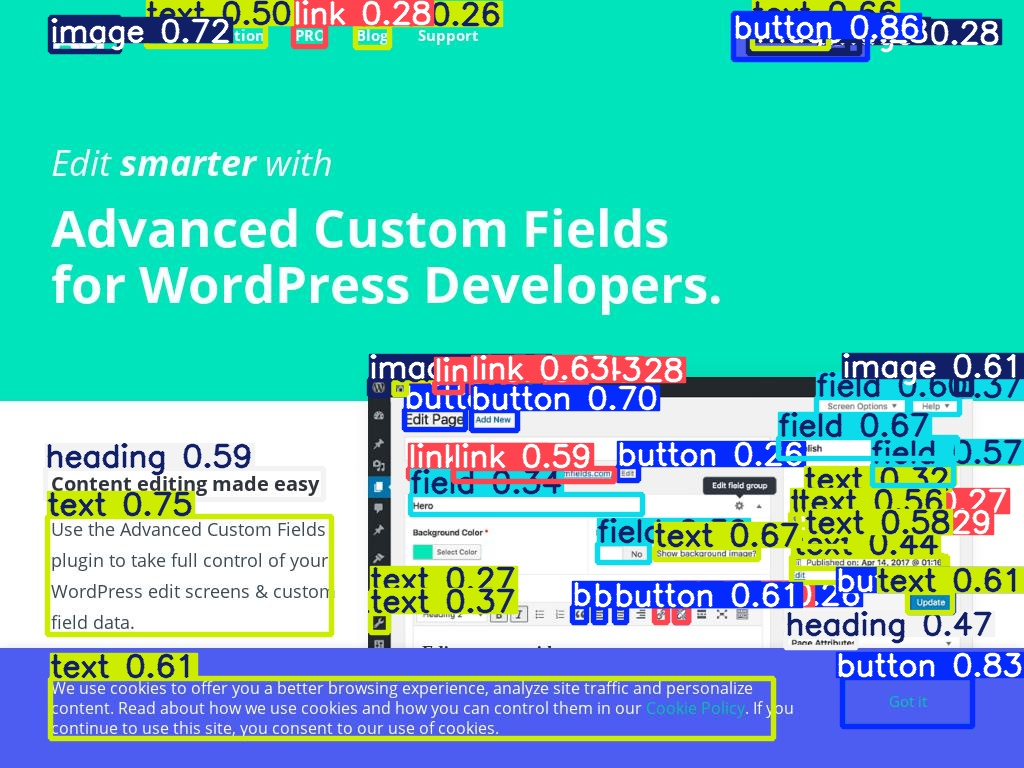

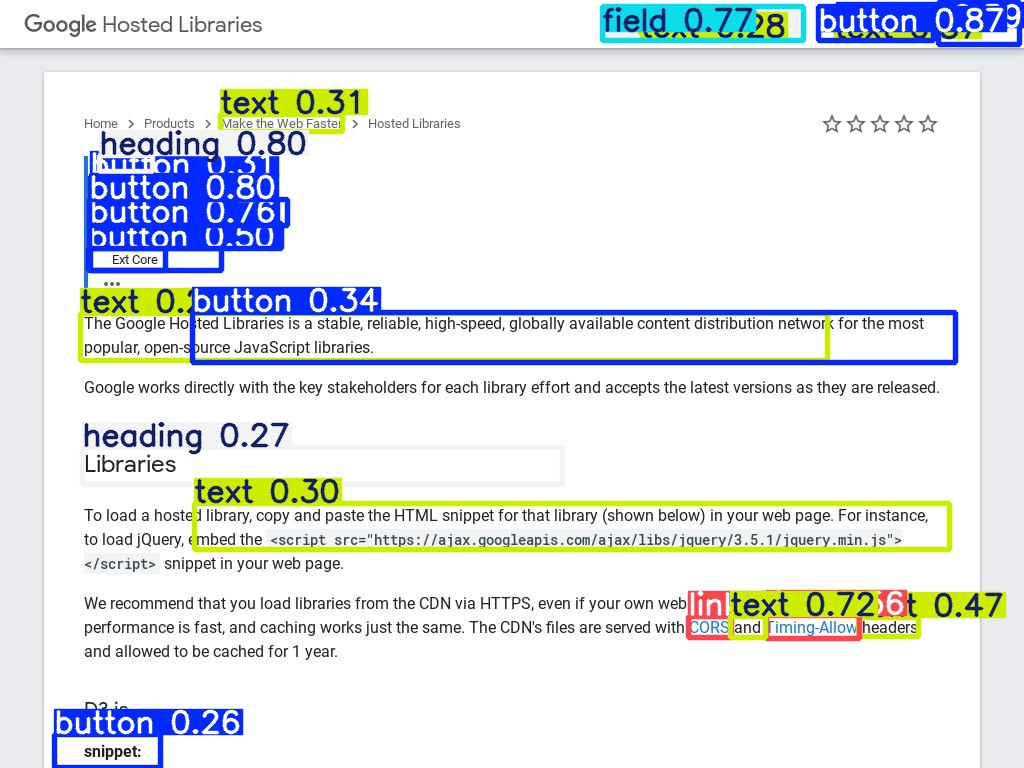

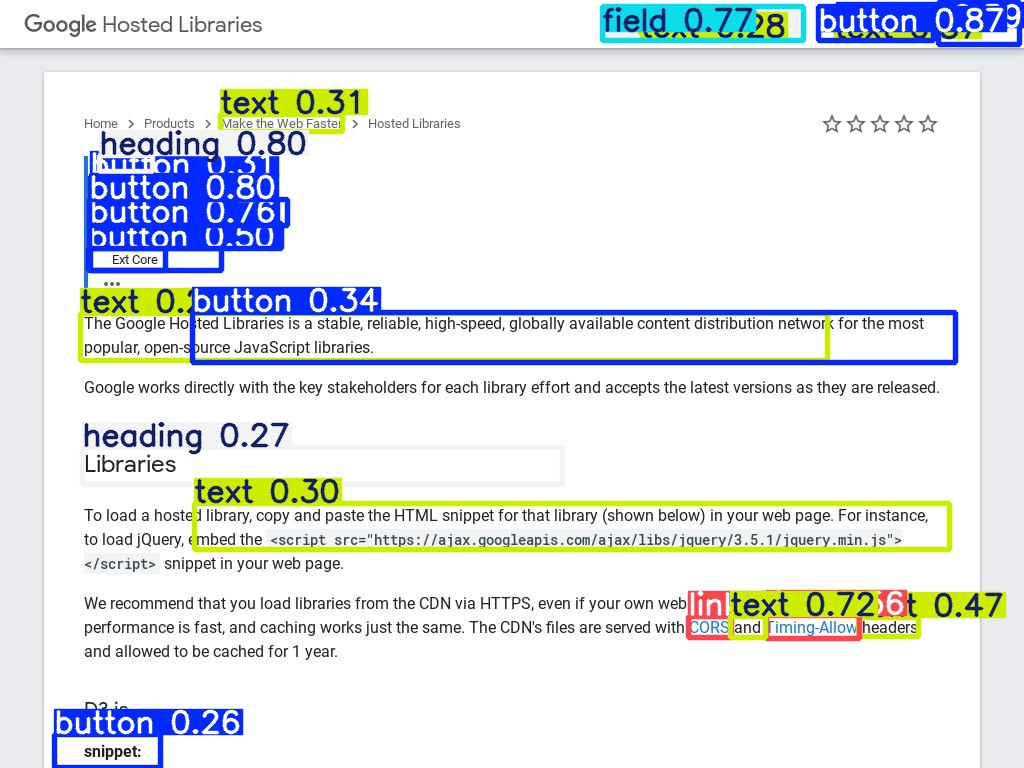

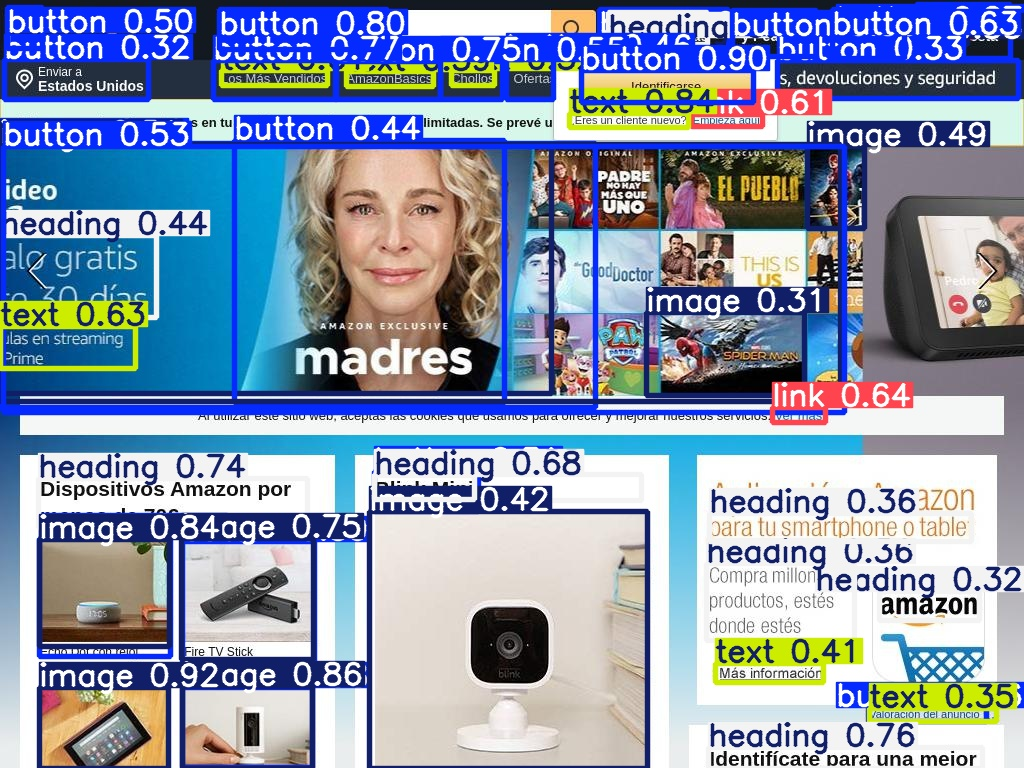

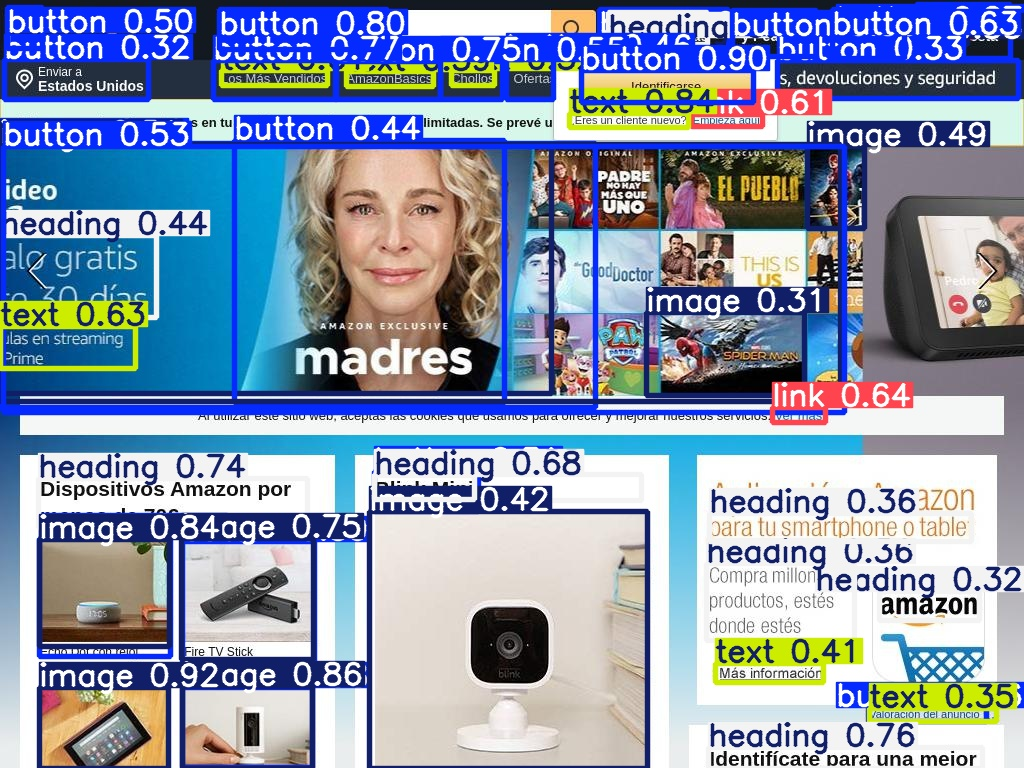

In [ ]:
counter =0
limit = 10
for image_path in glob.glob(f'{HOME}/datasets/runs/detect/predict/*.jpg'):
      display(Image(filename=image_path))
      print("\n")
      counter += 1
      if counter == limit:
          break